# Exploratory Data Analysis

Table of contents <a id='top'>

1. [Calendar](#calendar)
2. [Reviews](#reviews)
1. [Listings](#listings)

In [29]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import os
from jupyterthemes import jtplot
from datetime import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

ROOT_DIR = '..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')

SRC_DIR = os.path.join(ROOT_DIR, 'src')

SEATTLE_CALENDAR = os.path.join(DATA_RAW, 'seattle', 'calendar.csv')
SEATTLE_LISTINGS = os.path.join(DATA_RAW, 'seattle', 'listings.csv')
SEATTLE_REVIEWS = os.path.join(DATA_RAW, 'seattle', 'reviews.csv')

SEATTLE_LISTINGS_COLS = os.path.join(
    DATA_INTERIM, 'seattle', 'listings_cols_df.pkl')

import sys
sys.path.append(SRC_DIR)
sys.path.append(os.path.join(SRC_DIR, 'data'))

import preprocessing as pp
import missing_data as md
import make_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# If the dataset is already processed comment the line below
# make_dataset.create_dataset()

In [3]:
calendar, listings, reviews = make_dataset.load_processed()

## 1. Calendar <a id='calendar'></a>
[Top](#top)

In [4]:
print(calendar.shape)
calendar.head()

(1393570, 4)


,listing_id,date,available,price
0,241032,2016-01-04,True,85.0
1,241032,2016-01-05,True,85.0
2,241032,2016-01-06,False,85.0
3,241032,2016-01-07,False,85.0
4,241032,2016-01-08,False,85.0


In [5]:
print('The data goes from {} to {}'.format(calendar.date.min(), 
                                           calendar.date.max()))

The data goes from 2016-01-04 00:00:00 to 2017-01-02 00:00:00


Is every listing_id in every date?

In [6]:
calendar.groupby('date').count().describe()

,listing_id,available,price
count,365.0,365.0,365.0
mean,3818.0,3818.0,3818.0
std,0.0,0.0,0.0
min,3818.0,3818.0,3818.0
25%,3818.0,3818.0,3818.0
50%,3818.0,3818.0,3818.0
75%,3818.0,3818.0,3818.0
max,3818.0,3818.0,3818.0


In [7]:
calendar.listing_id.value_counts().describe()

count    3818.0
mean      365.0
std         0.0
min       365.0
25%       365.0
50%       365.0
75%       365.0
max       365.0
Name: listing_id, dtype: float64

In [8]:
calendar.shape[0] == 365 * 3818

True

It looks like "calendar" has one entry for every listing_id present, for every date. A better way to represent that kind of data may be to transform it to some time series.

In [9]:
price_ts = calendar.pivot_table(index='date',
                                columns='listing_id',
                                values='price')
print(price_ts.shape)
price_ts.head()

(365, 3818)


listing_id,3335,4291,5682,6606,7369,9419,9460,9531,9534,9596,...,10309898,10310373,10318171,10319529,10331249,10332096,10334184,10339144,10339145,10340165
date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,120.0,82.0,50.0,90.0,85.0,70.0,109.0,165.0,125.0,120.0,...,250.0,20.0,50.0,49.0,45.0,40.0,120.0,60.0,219.0,43.0
2016-01-05,120.0,82.0,50.0,90.0,85.0,70.0,109.0,165.0,125.0,120.0,...,250.0,20.0,50.0,49.0,45.0,40.0,120.0,60.0,219.0,43.0
2016-01-06,120.0,82.0,50.0,90.0,85.0,70.0,109.0,165.0,125.0,120.0,...,250.0,20.0,50.0,49.0,45.0,40.0,120.0,60.0,219.0,43.0
2016-01-07,120.0,82.0,50.0,90.0,85.0,70.0,109.0,165.0,125.0,120.0,...,250.0,20.0,50.0,49.0,45.0,40.0,120.0,60.0,219.0,43.0
2016-01-08,120.0,82.0,50.0,100.0,85.0,70.0,109.0,165.0,125.0,125.0,...,250.0,20.0,50.0,49.0,45.0,40.0,120.0,60.0,219.0,43.0


In [49]:
avail_ts = calendar.pivot_table(index='date',
                                columns='listing_id',
                                values='available',
                                aggfunc=lambda x: x)
print(avail_ts.shape)
avail_ts.head()

(365, 3818)


listing_id,3335,4291,5682,6606,7369,9419,9460,9531,9534,9596,...,10309898,10310373,10318171,10319529,10331249,10332096,10334184,10339144,10339145,10340165
date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,False,True,False,True,False,True,True,False,False,True,...,True,False,False,False,False,True,False,False,True,False
2016-01-05,False,True,False,True,False,True,True,False,False,True,...,True,False,True,False,False,True,False,False,True,False
2016-01-06,False,True,False,True,False,True,False,False,False,True,...,True,False,True,False,False,True,False,False,True,False
2016-01-07,False,True,False,True,False,True,False,False,False,True,...,True,False,True,False,False,True,False,False,True,False
2016-01-08,False,True,False,True,False,True,False,False,False,True,...,True,True,True,False,False,True,True,False,True,False


Which percentage of the properties are available during the year?

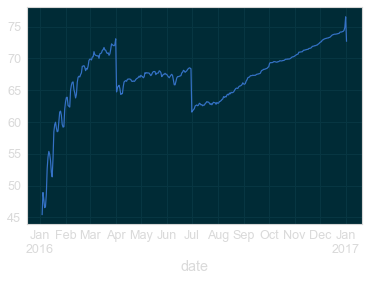

In [11]:
(100*avail_ts.mean(axis=1)).plot()

How does the mean price evolve in the year?

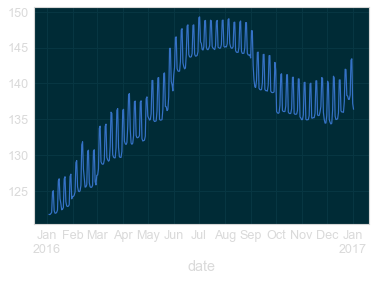

In [12]:
price_ts.mean(axis=1).plot()

It looks like it has a weekly seasonality, and a yearly seasonality, plus an upwards trend.

Are the price movements correlated to each other?

In [13]:
price_corr = price_ts.corr()

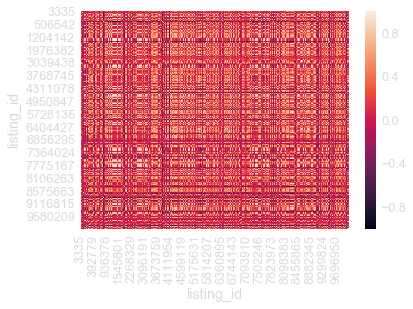

In [14]:
sns.heatmap(price_corr)

Let's find some clusters...

In [15]:
import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(ts):
    """ 
    Clusters the time series according to their correlation.
    Part of the code was taken from here: 
    https://github.com/TheLoneNut/CorrelationMatrixClustering/blob/master/
    CorrelationMatrixClustering.ipynb
    """
    X = ts.corr().fillna(0).values
    d = sch.distance.pdist(X)
    L = sch.linkage(d, method='complete')
    ind = sch.fcluster(L, 0.5*d.max(), 'distance')
    columns = [ts.columns.tolist()[i] for i in list((np.argsort(ind)))]
    clmts = ts.reindex_axis(columns, axis=1)
    return clmts, ind

In [16]:
clmts, ind = cluster_corr(price_ts)

/Users/antelinvestigacionydesarrollo/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  app.launch_new_instance()


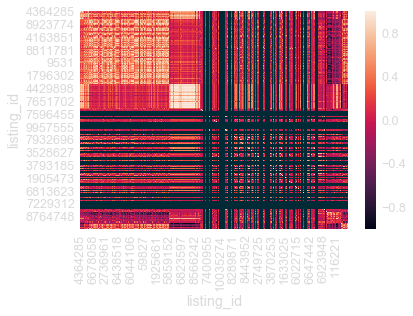

In [17]:
clustered_corr = clmts.corr()
sns.heatmap(clustered_corr)

In [18]:
clustered_corr.isnull().sum().sum()

10103899

In [19]:
filtered_corr = clustered_corr.dropna(thresh=0.99).dropna(thresh=0.99, axis=1)
filtered_corr.isnull().sum().sum()

0

In [20]:
filtered_corr.shape

(2115, 2115)

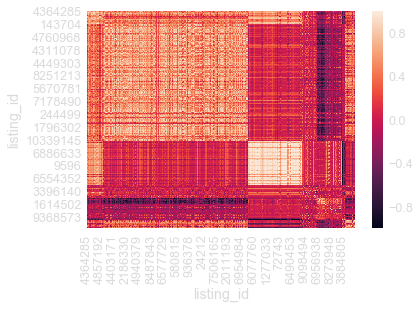

In [21]:
sns.heatmap(filtered_corr)

Text(0.5,1,'Means of the clusters in time')

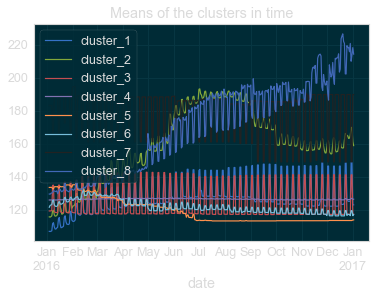

In [22]:
cluster_ids = np.unique(ind)
mean_dict = {'cluster_' + str(c): price_ts.loc[:,ind==c].mean(axis=1)
             for c in cluster_ids}
cluster_means = pd.DataFrame(mean_dict)
cluster_means.plot()
plt.title('Means of the clusters in time')

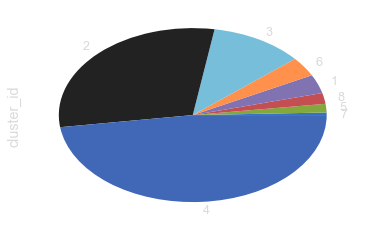

In [23]:
clusters = pd.DataFrame(ind, index=price_ts.columns, columns=['cluster'])
clusters.cluster.value_counts().sort_values().plot.pie(label='cluster_id')

## 2. Reviews <a id='reviews'></a>
[Top](#top)

In [24]:
print(reviews.shape)
reviews.head()

(84831, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [25]:
reviews.listing_id.value_counts().shape[0]

3191

In [26]:
reviews.id.value_counts().shape[0]

84831

So, the "id" column identifies a review uniquely

In [27]:
print(reviews.reviewer_id.value_counts().shape[0])
reviews.reviewer_id.value_counts()[:5]

75717


206203      67
15121499    32
2734499     19
5775807     19
29590276    18
Name: reviewer_id, dtype: int64

The reviewer name doesn't seem like an important feature.

Text(0.5,1,'Amount of reviews in time')

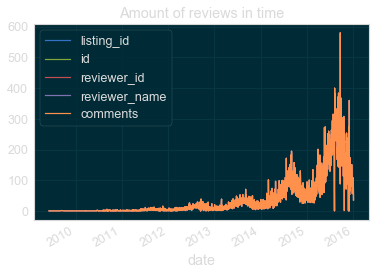

In [28]:
reviews.groupby('date').count().plot()
plt.title('Amount of reviews in time')

The number of reviews seems to be seasonal (annually), and also has an upward trend. Looks like a good fit for a multiplicative model.

The comments could be used for sentiment analysis.

## 3. Listings <a id='listings'></a>
[Top](#top)

In [30]:
print(listings.shape)
listings.head()

(3816, 98)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,calculated_host_listings_count,reviews_per_month,review_scores_rating_missing,review_scores_accuracy_missing,review_scores_cleanliness_missing,review_scores_checkin_missing,review_scores_communication_missing,review_scores_location_missing,review_scores_value_missing,reviews_per_month_missing
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,,...,2,4.070000,0,0,0,0,0,0,0,0
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,6,1.480000,0,0,0,0,0,0,0,0
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,2,1.150000,0,0,0,0,0,0,0,0
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,,A charming apartment that sits atop Queen Anne...,none,,...,1,2.078919,1,1,1,1,1,1,1,1
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,1,0.890000,0,0,0,0,0,0,0,0


In [32]:
listings.neighbourhood.unique().shape[0]

96

There is data for 96 neighborhoods

In [45]:
(listings.neighbourhood.value_counts() > 20).sum()

38

But only 38 have more than 20 samples (I wouldn't get statistical features from the others)

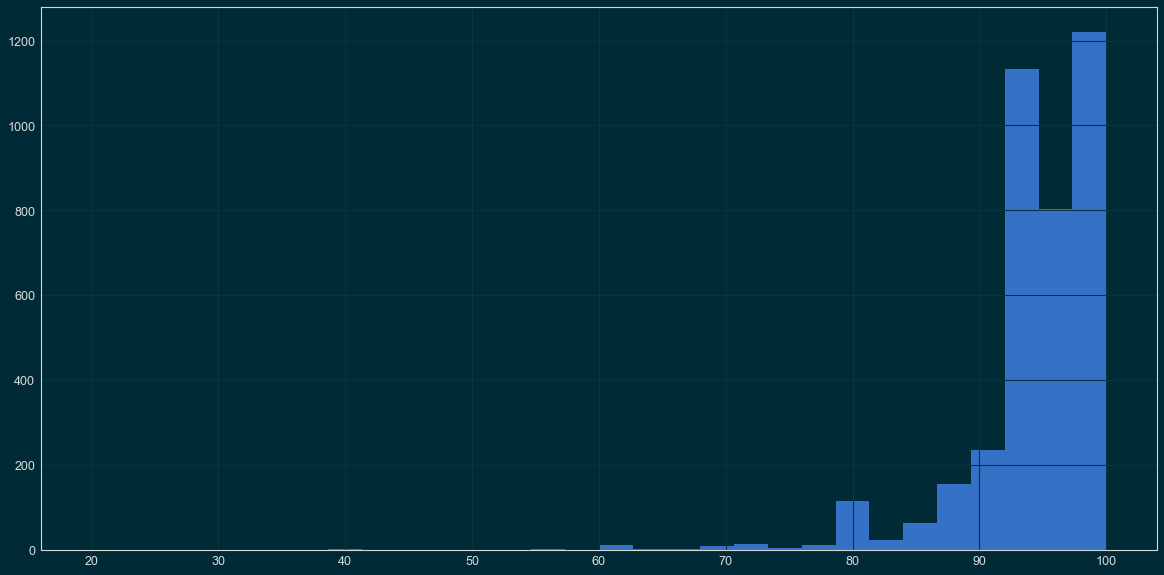

In [38]:
listings.review_scores_rating.hist(bins=30)

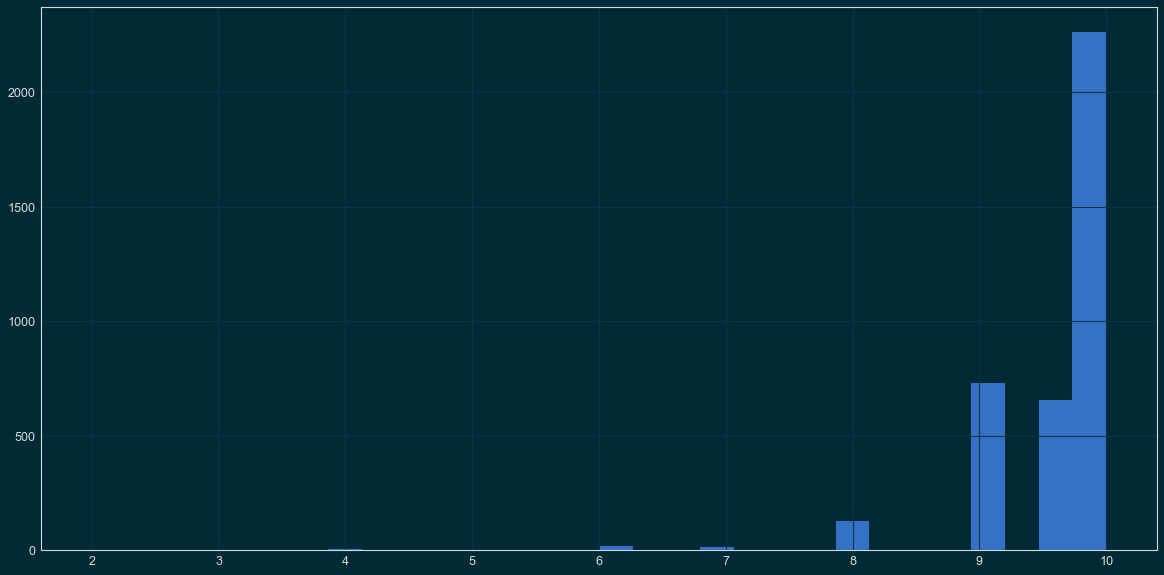

In [37]:
listings.review_scores_accuracy.hist(bins=30)

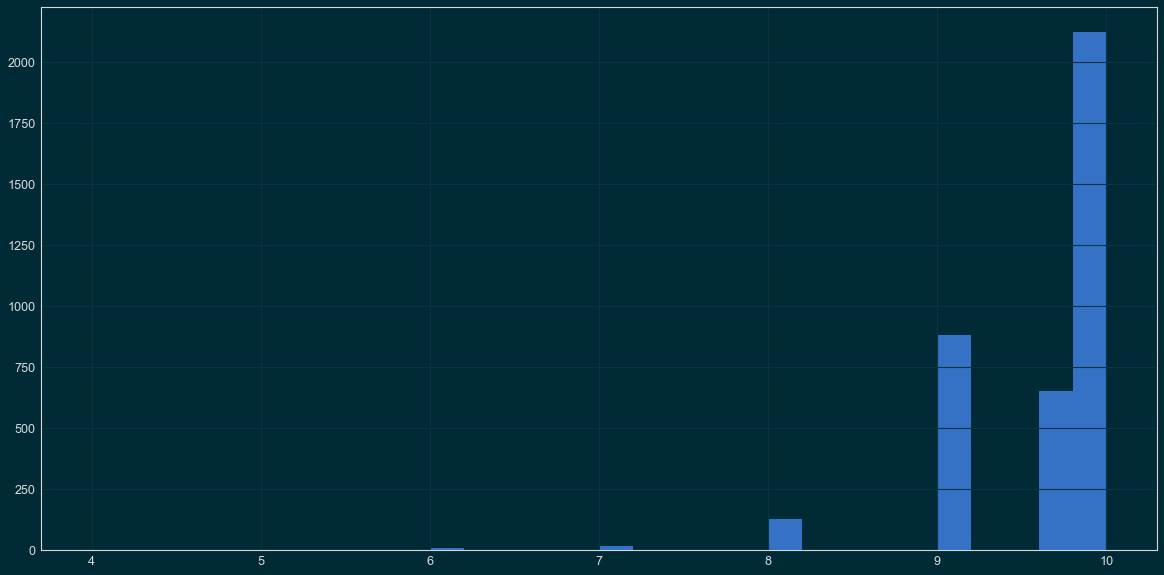

In [40]:
listings.review_scores_location.hist(bins=30)

In [41]:
listings.review_scores_location_missing.mean()

0.1711215932914046

In [42]:
listings.review_scores_rating_missing.mean()

0.1690251572327044

In [48]:
(listings.description == '').mean()

0.0

OK, every listing has a desription. That could be used to cluster them by their description.